# Libraries

In [29]:
import os
import datetime
import math

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

# visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')

# keras model
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

import keras.backend as K

# preprocessing
from sklearn.preprocessing import StandardScaler

# tuning


# generalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Fetching

In [6]:
# define csv path
datapath = '../data/interim/household_unique/household_power_consumption_interim.csv'

In [7]:
# import / read dateset file
ts_house = pd.read_csv(datapath, low_memory=False)

# Data Scrubbing

In [8]:
# renaming columns for better readability
ts_house.columns = ts_house.columns.str.lower()

In [69]:
ts_house.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [7]:
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   global_active_power    34589 non-null  float64
 1   global_reactive_power  34589 non-null  float64
 2   voltage                34589 non-null  float64
 3   global_intensity       34589 non-null  float64
 4   sub_metering_1         34589 non-null  float64
 5   sub_metering_2         34589 non-null  float64
 6   sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1+ MB


In [8]:
ts_house.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,64.674459,7.329660,14268.938222,274.178918,66.470121,76.932869,382.640926
std,53.995513,4.066808,1608.365811,226.097083,211.089850,250.148948,440.306805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.218000,4.618000,14344.730000,89.400000,0.000000,0.000000,38.000000
50%,46.948000,6.364000,14455.770000,200.400000,0.000000,19.000000,99.000000
75%,94.206000,8.920000,14560.290000,393.800000,0.000000,39.000000,837.000000
max,393.632000,46.460000,15114.120000,1703.000000,2902.000000,2786.000000,1293.000000


# Data cleaning

## Missing values

In [19]:
ts_house.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Duplicates

In [20]:
ts_house.duplicated().value_counts()

False    34589
dtype: int64

---------------

# Model Building

## Time-series to-supervised problem

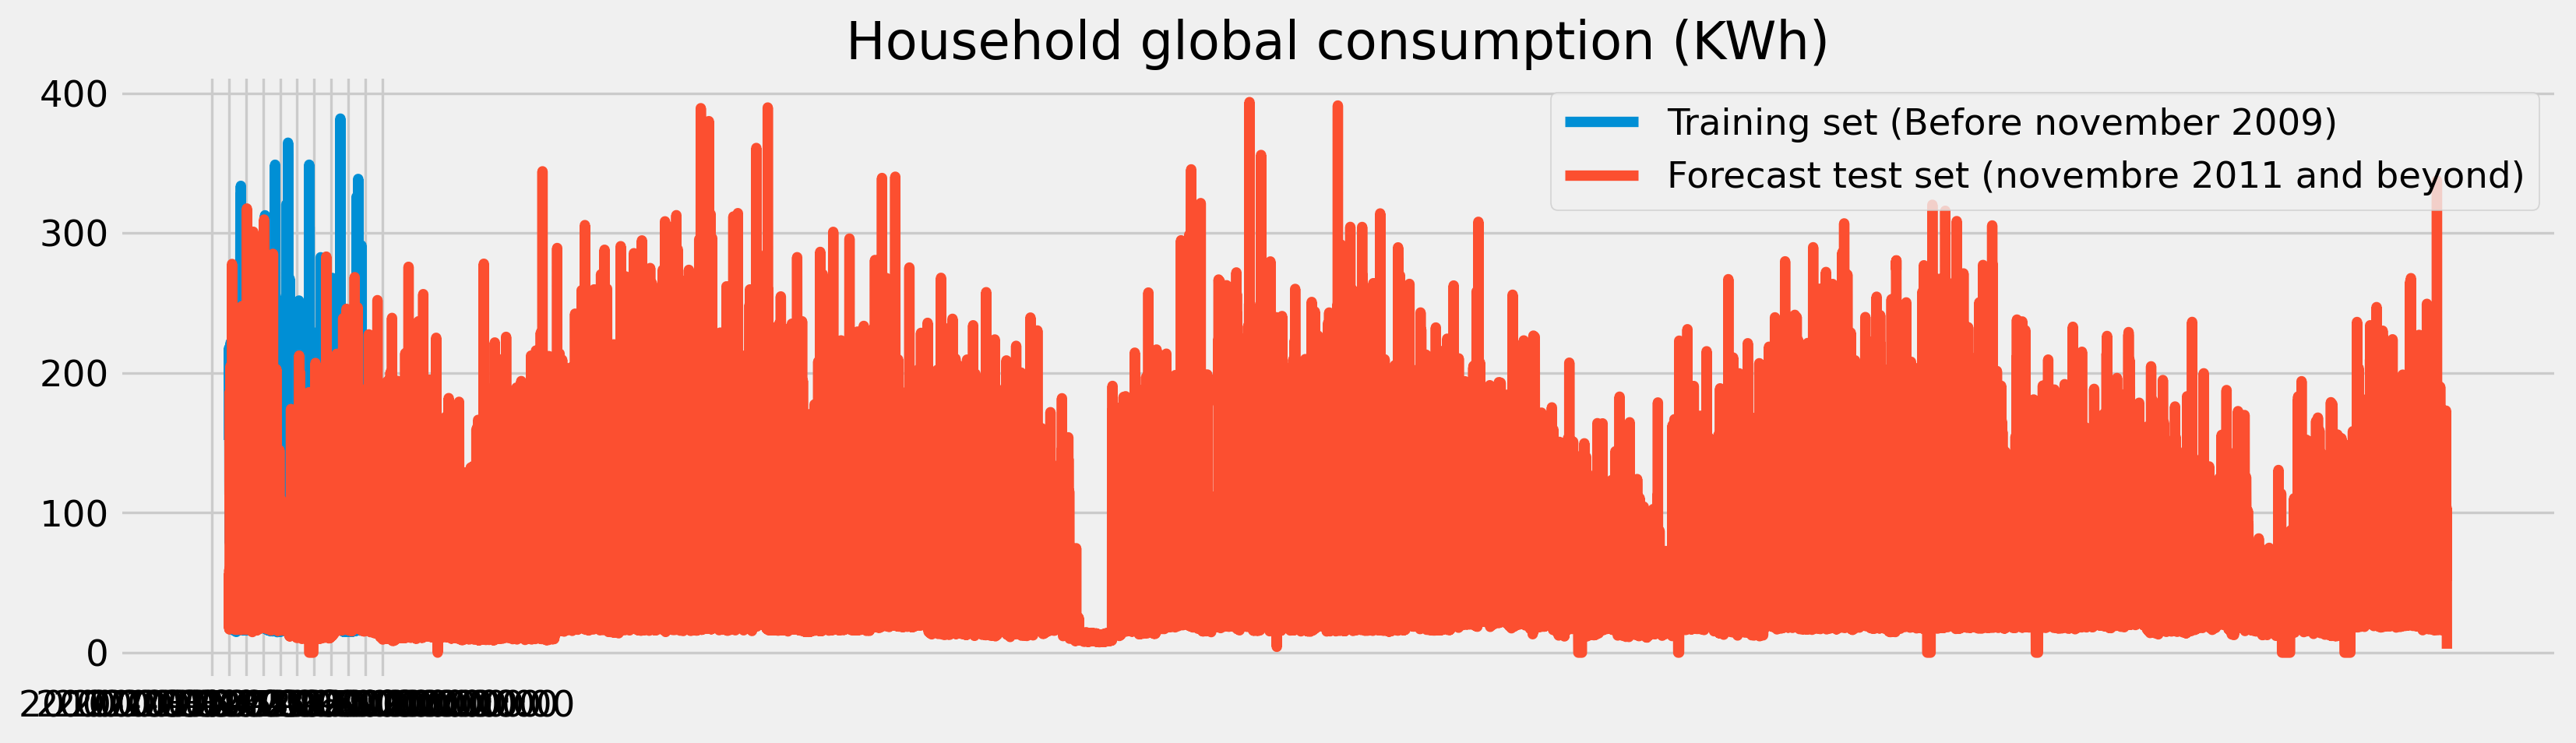

In [47]:
#split time series into train/forecast sets
ts_train = ts_house["global_active_power"][:2009-11]
ts_forecast = ts_house["global_active_power"][2009-11:]

# We have chosen 'High' attribute for prices. Let's see what it looks like
ts_train.plot(legend=True)
ts_forecast.plot(legend=True)
plt.legend(['Training set (Before november 2009)','Forecast test set (novembre 2011 and beyond)'])
plt.title('Household global consumption (KWh)')
plt.show()

In [9]:
def ts_to_supervised(df):
    # split time series train/forecast sets
    ts_train = df[:2009-11]
    ts_forecast = df[2009-11:]

    # split time series into train/test sets
    X_train = ts_train.iloc[:, 1:].values
    y_train = ts_train['global_active_power'].values

    X_test = ts_forecast.iloc[:, 1:].values
    y_test = ts_forecast['global_active_power'].values

    # define standardscaler scaling method
    scaler = StandardScaler()

    # normalisation
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # split train/test sets
    time_steps = 24
    batch_size = 50

    ## train split set
    train_gnr = TimeseriesGenerator(X_train, y_train,
                            length=time_steps,
                            batch_size=batch_size
                            )

    ## test split set
    test_gnr = TimeseriesGenerator(X_test, y_test,
                            length=time_steps,
                            batch_size=64
                            )

    return train_gnr, test_gnr

Keras provides the TimeseriesGenerator that can be used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.

![image-ts_generator](https://machinelearningmastery.com/wp-content/uploads/2021/09/rnnCode2-1024x543.png)

------------------------------------

## Baseline model

### Model Instantiation

In [10]:
# define optimzer paramaters
optimizer = Adam(lr=0.005)

In [11]:
# define early-stopping regularization 
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')

In [49]:
# define model building function
def rnn(train_generator, test_generator, callback_, optimizer, time_steps, epoch, batch, verbose):
    model = Sequential()
    model.add(SimpleRNN(100, activation='sigmoid', input_shape=(time_steps, 6)))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss="mse", metrics="mse")
    model.fit(train_generator,
                batch_size=batch,
                epochs= epoch,
                verbose=verbose,
                callbacks=[callback_],
                validation_data=(test_generator),
                shuffle=False)
    return model

In [50]:
# model instantiation
epoch = 1050
batch = 64
verbose = 2
dropout = 0.2
time_steps = 24

# define generators for model instantiation
train_gnr, test_gnr = ts_to_supervised(ts_house)

base_model = rnn(train_gnr, test_gnr, callback, optimizer, time_steps, epoch, batch, verbose)

Epoch 1/1050
40/40 - 4s - loss: 9971.7041 - mse: 9971.7041 - val_loss: 3380.6995 - val_mse: 3380.6995 - 4s/epoch - 111ms/step
Epoch 2/1050
40/40 - 3s - loss: 6782.5044 - mse: 6782.5044 - val_loss: 2785.1101 - val_mse: 2785.1101 - 3s/epoch - 82ms/step
Epoch 3/1050
40/40 - 3s - loss: 5701.7197 - mse: 5701.7197 - val_loss: 2776.0852 - val_mse: 2776.0852 - 3s/epoch - 72ms/step
Epoch 4/1050
40/40 - 3s - loss: 5270.2676 - mse: 5270.2676 - val_loss: 2897.0957 - val_mse: 2897.0957 - 3s/epoch - 77ms/step
Epoch 5/1050
40/40 - 3s - loss: 5079.8037 - mse: 5079.8037 - val_loss: 3029.3516 - val_mse: 3029.3516 - 3s/epoch - 70ms/step
Epoch 6/1050
40/40 - 3s - loss: 4991.3379 - mse: 4991.3379 - val_loss: 3140.1672 - val_mse: 3140.1672 - 3s/epoch - 80ms/step
Epoch 7/1050
40/40 - 3s - loss: 4948.7007 - mse: 4948.7007 - val_loss: 3224.3115 - val_mse: 3224.3115 - 3s/epoch - 73ms/step
Epoch 8/1050
40/40 - 3s - loss: 4927.4082 - mse: 4927.4082 - val_loss: 3285.1514 - val_mse: 3285.1514 - 3s/epoch - 79ms/step

### Performance

In [26]:
def plot_validate(model_name, model):
    '''Plot model accuracy or loss for both train and test validation per epoch
    model = fitted model
    '''
    history = model.history

    # define figure plot
    fig = plt.figure()

    # summarize history for accuracy score
    fig.add_subplot(121) ## accuracy subplot
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('Mean squared error curve')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    fig.add_subplot(122) ## loss subplot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.legend(['Train', 'Test'])
    plt.savefig(f'../reports/model/{model_name}_batch({batch_size})_epoch({epoch})_tsteps({time_steps})_dropout({dropout})_loss_function.png')
    plt.show()


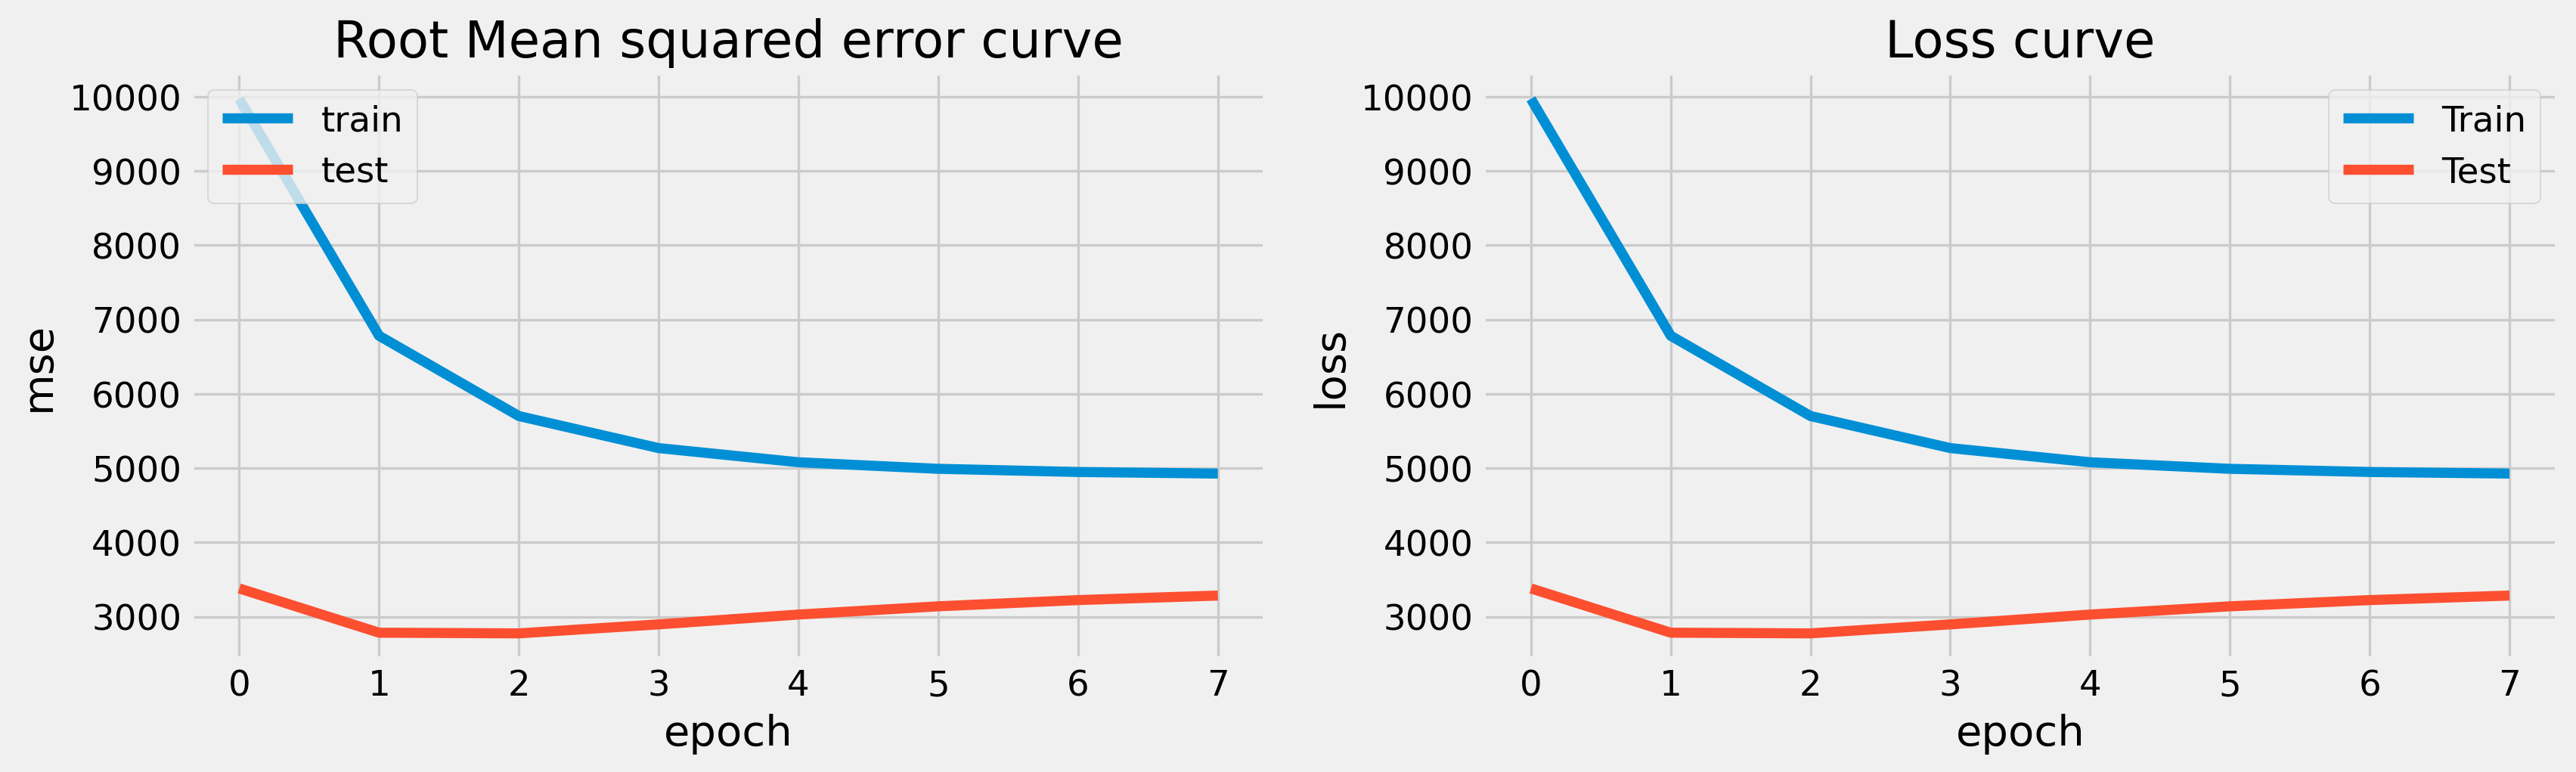

In [58]:
# draw loss graph
plot_validate('rnn_baseline', base_model)

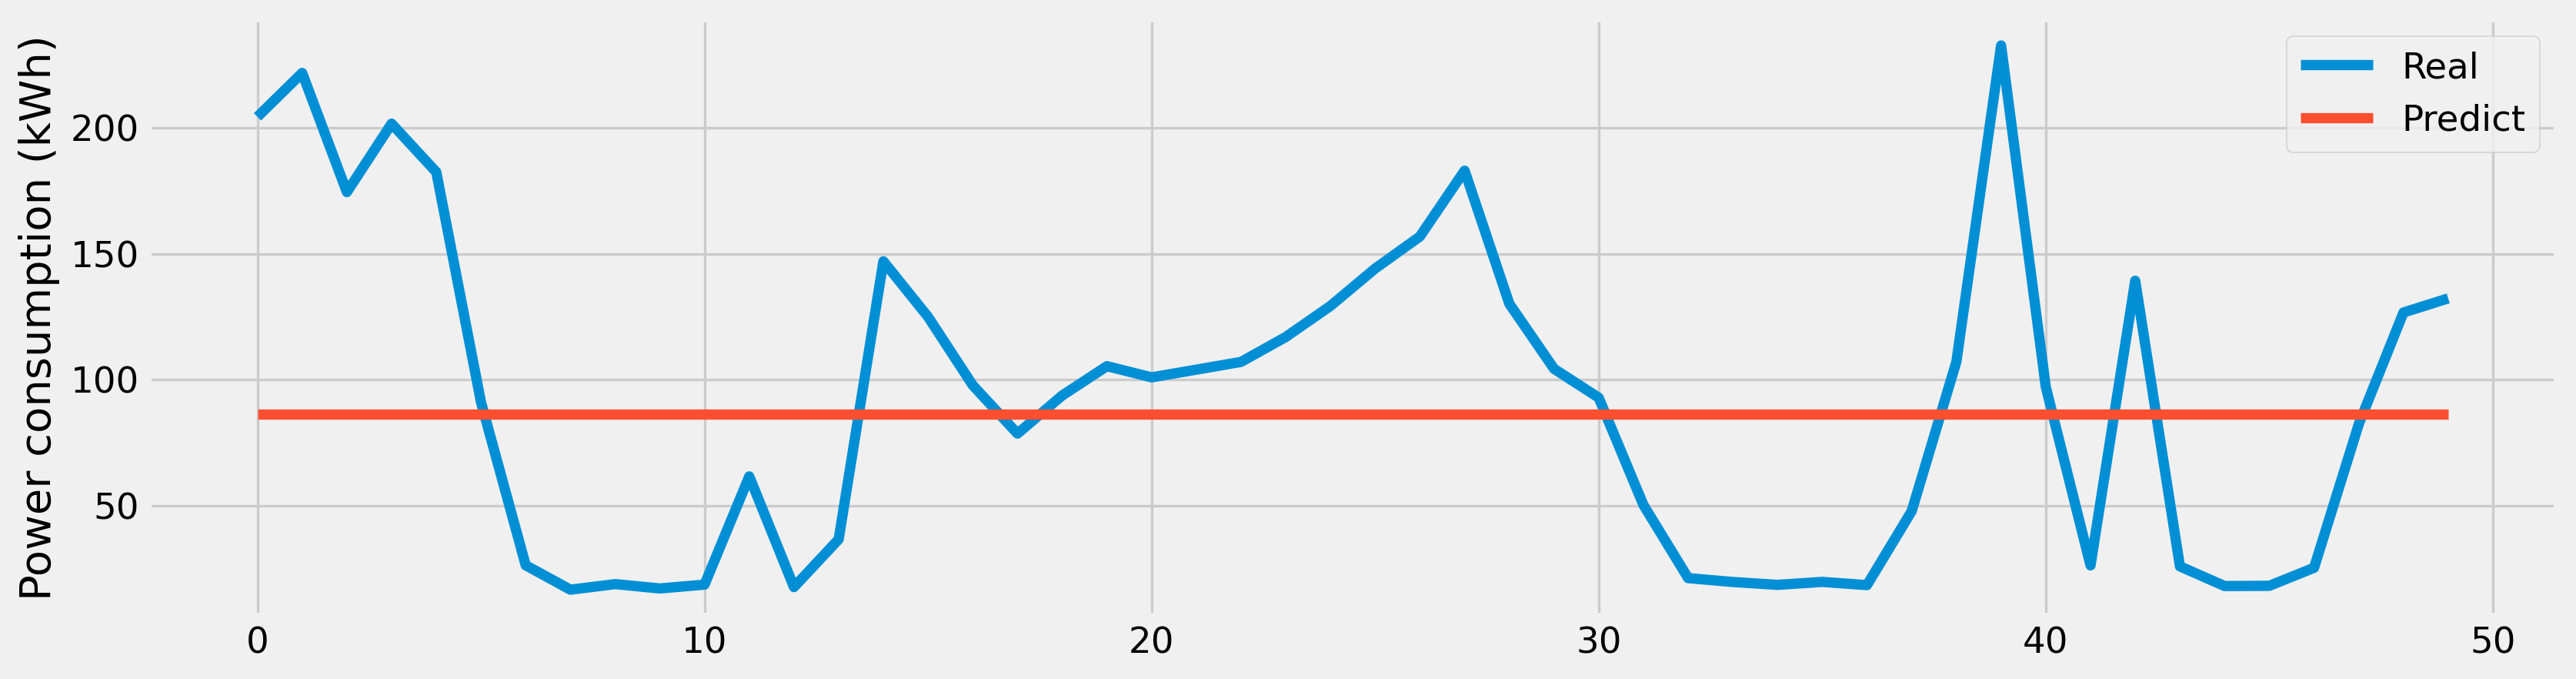

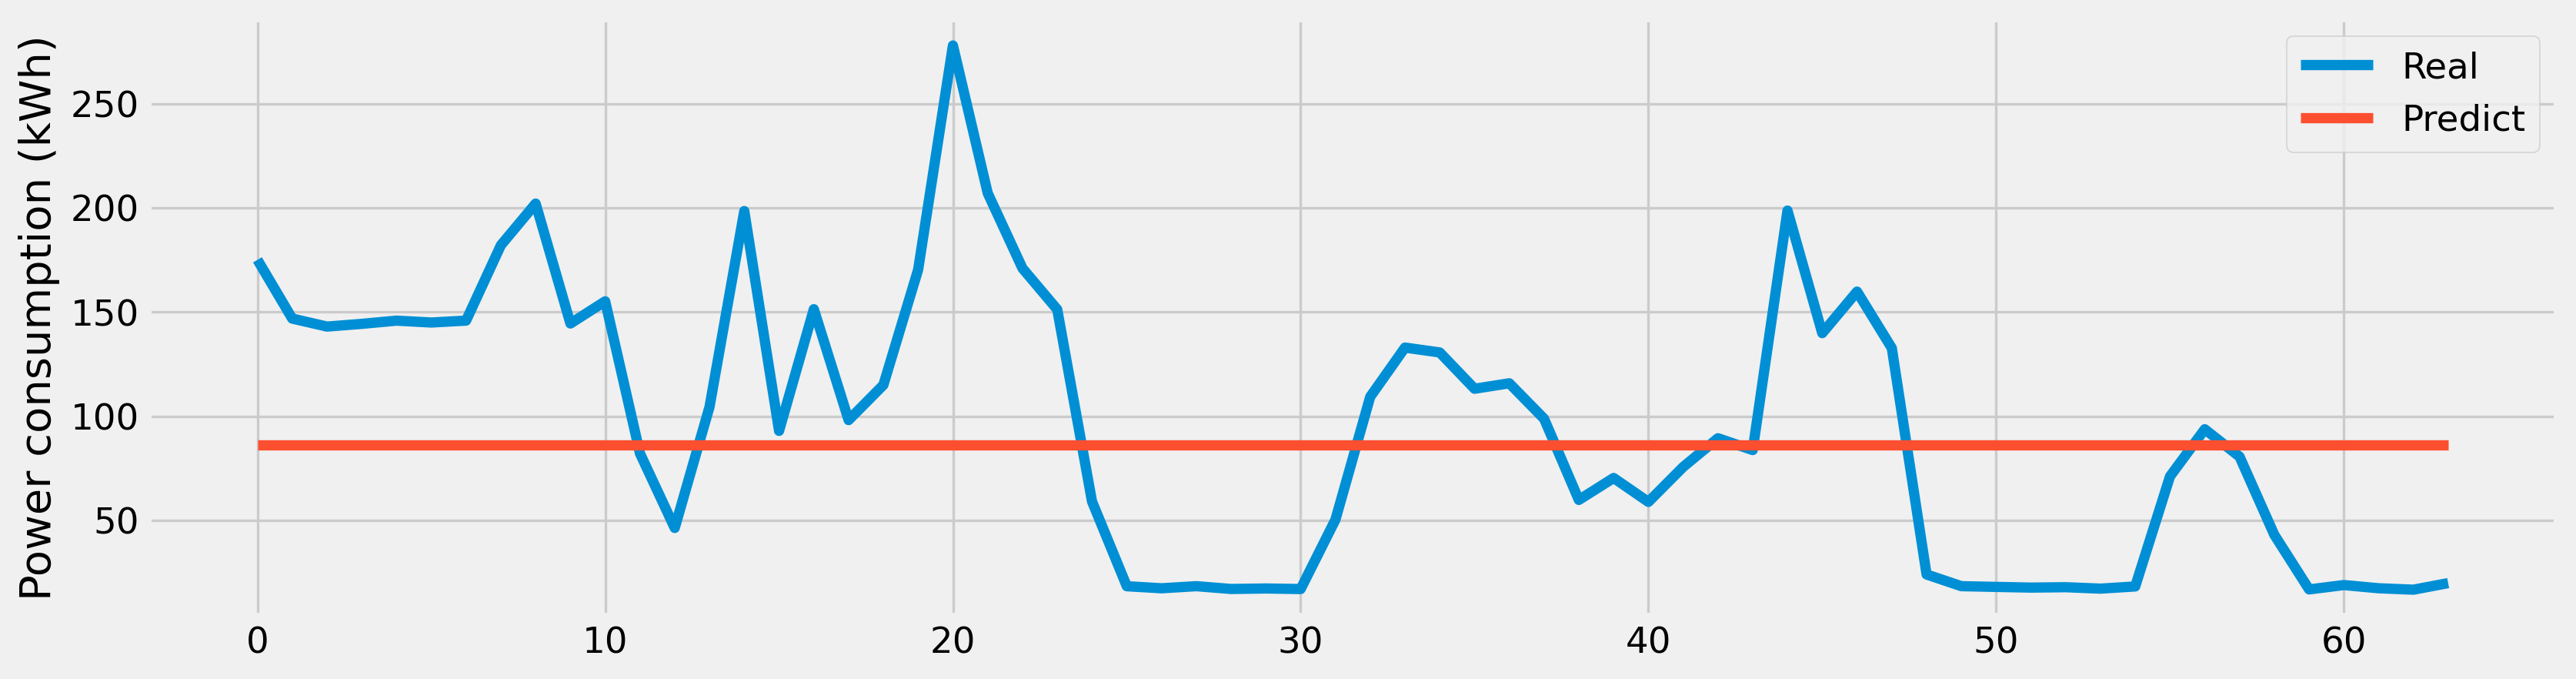

In [60]:
# define train/test splits from generators for prediction plots
X_train, y_train = train_gnr[0][0], train_gnr[0][1]
X_test, y_test = test_gnr[0][0], test_gnr[0][1]

# draw train & test prediction
predict_train = base_model.predict(X_train)
predict_test = base_model.predict(X_test)

for real, predict in [(y_train, predict_train),(y_test, predict_test)]:
    plt.figure()
    plt.plot(real)
    plt.plot(predict)
    plt.ylabel('Power consumption (kWh)');
    plt.legend(['Real', 'Predict']);

## LSTM

In [61]:
# define optimzer paramaters
optimizer = Adam(lr=0.005)

In [62]:
# define early-stopping regularization 
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')

In [63]:
def lstm(train_generator, test_generator, callaback_, optimizer, time_steps, n_features, epoch, batch, verbose, dropout):
    model = Sequential()
    # return sequences refer to all the outputs of the memory cells, True if next layer is LSTM
    model.add(LSTM(150, dropout=dropout, return_sequences=True, input_shape=(time_steps, n_features)))
    model.add(LSTM(150, dropout=dropout, return_sequences=False))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics='mse')
    model.fit(train_generator,
                batch_size=batch,
                epochs= epoch,
                callbacks=[callaback_],
                verbose=verbose,
                validation_data=(test_generator))
    return model

In [64]:
# model instantiation
epoch = 150
batch = 64
verbose = 2
dropout = 0.2
n_features = 6
time_steps = 24

lstm_model = lstm(train_gnr, test_gnr, callback, optimizer, time_steps, n_features, epoch, batch, verbose, dropout)

Epoch 1/150
40/40 - 31s - loss: 9575.6445 - mse: 9575.6445 - val_loss: 3481.6909 - val_mse: 3481.6909 - 31s/epoch - 773ms/step
Epoch 2/150
40/40 - 25s - loss: 6853.2993 - mse: 6853.2998 - val_loss: 2808.2493 - val_mse: 2808.2493 - 25s/epoch - 615ms/step
Epoch 3/150
40/40 - 23s - loss: 5649.4907 - mse: 5649.4907 - val_loss: 2791.7185 - val_mse: 2791.7185 - 23s/epoch - 566ms/step
Epoch 4/150
40/40 - 23s - loss: 5142.5835 - mse: 5142.5840 - val_loss: 2959.8201 - val_mse: 2959.8201 - 23s/epoch - 585ms/step
Epoch 5/150
40/40 - 24s - loss: 4978.0503 - mse: 4978.0503 - val_loss: 3158.1636 - val_mse: 3158.1636 - 24s/epoch - 594ms/step
Epoch 6/150
40/40 - 22s - loss: 4948.3408 - mse: 4948.3408 - val_loss: 3360.0117 - val_mse: 3360.0117 - 22s/epoch - 545ms/step
Epoch 7/150
40/40 - 23s - loss: 4908.9746 - mse: 4908.9746 - val_loss: 3343.8120 - val_mse: 3343.8120 - 23s/epoch - 568ms/step
Epoch 8/150
40/40 - 23s - loss: 4902.8911 - mse: 4902.8911 - val_loss: 3352.3079 - val_mse: 3352.3079 - 23s/epo

### Performance

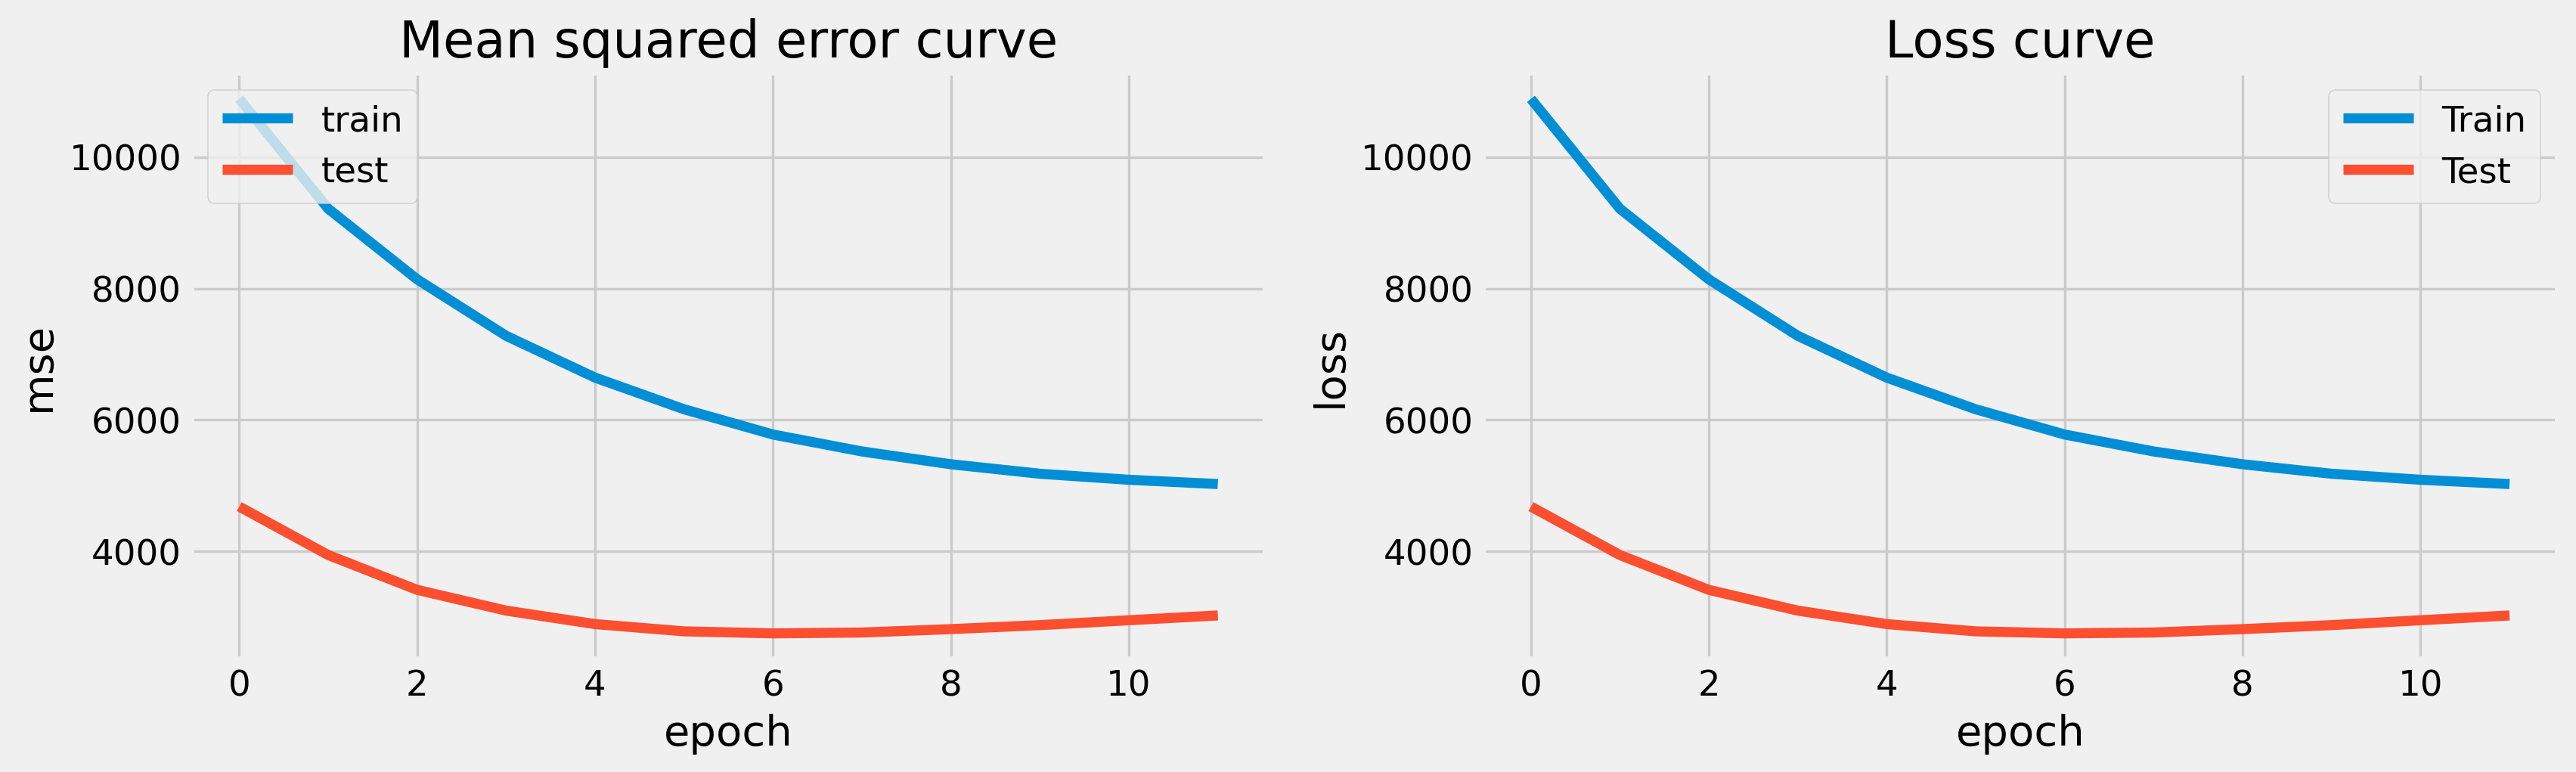

In [37]:
# plot loss funtion / learning curves
plot_validate('lstm', lstm_model)

## GRU

In [14]:
# define optimzer paramaters
optimizer = RMSprop(lr=0.005)

In [15]:
# define early-stopping regularization 
callback = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='min')

In [40]:
def gru(train_generator, test_generator, callaback_, optimizer, time_steps, n_features, epoch, verbose, dropout):
    # The GRU architecture
    model = Sequential()
    # First GRU layer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, n_features), activation='tanh'))
    model.add(Dropout(dropout))
    # Second GRU layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, n_features), activation='tanh'))
    model.add(Dropout(dropout))
    # Third GRU layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, n_features), activation='tanh'))
    model.add(Dropout(dropout))
    # Fourth GRU layer
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(dropout))
    # The output layer
    model.add(Dense(units=1))
    # Compiling the RNN
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics='mse')

    # Fitting to the training set
    model.fit_generator(train_generator,
                epochs= epoch,
                callbacks=[callaback_],
                verbose=verbose,
                validation_data=(test_generator))

    return model

In [42]:
# model instantiation
epoch = 150
verbose = 2
dropout = 0.2
n_features = 6
time_steps = 24

# define generators for model instantiation
train_gnr, test_gnr = ts_to_supervised(ts_house)

gru_model = gru(train_gnr, test_gnr, callback, optimizer, time_steps, n_features, epoch, verbose, dropout)

Epoch 1/150
40/40 - 27s - loss: 10554.7012 - mse: 10554.7012 - val_loss: 4588.3149 - val_mse: 4588.3149 - 27s/epoch - 667ms/step
Epoch 2/150
40/40 - 13s - loss: 9115.7148 - mse: 9115.7148 - val_loss: 3899.5881 - val_mse: 3899.5881 - 13s/epoch - 329ms/step
Epoch 3/150
40/40 - 13s - loss: 8046.0615 - mse: 8046.0615 - val_loss: 3388.5359 - val_mse: 3388.5359 - 13s/epoch - 329ms/step
Epoch 4/150
40/40 - 12s - loss: 7170.3291 - mse: 7170.3286 - val_loss: 3041.3286 - val_mse: 3041.3286 - 12s/epoch - 302ms/step
Epoch 5/150
40/40 - 12s - loss: 6515.5566 - mse: 6515.5566 - val_loss: 2848.4766 - val_mse: 2848.4766 - 12s/epoch - 307ms/step
Epoch 6/150
40/40 - 12s - loss: 5951.3760 - mse: 5951.3760 - val_loss: 2744.8311 - val_mse: 2744.8311 - 12s/epoch - 298ms/step
Epoch 7/150
40/40 - 12s - loss: 5594.1216 - mse: 5594.1216 - val_loss: 2731.4736 - val_mse: 2731.4736 - 12s/epoch - 300ms/step
Epoch 8/150
40/40 - 15s - loss: 5298.5713 - mse: 5298.5713 - val_loss: 2814.5261 - val_mse: 2814.5261 - 15s/e

In [43]:
# plot model architecture
model_to_dot(
    gru_model, show_shapes=False, show_dtype=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96, subgraph=False
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


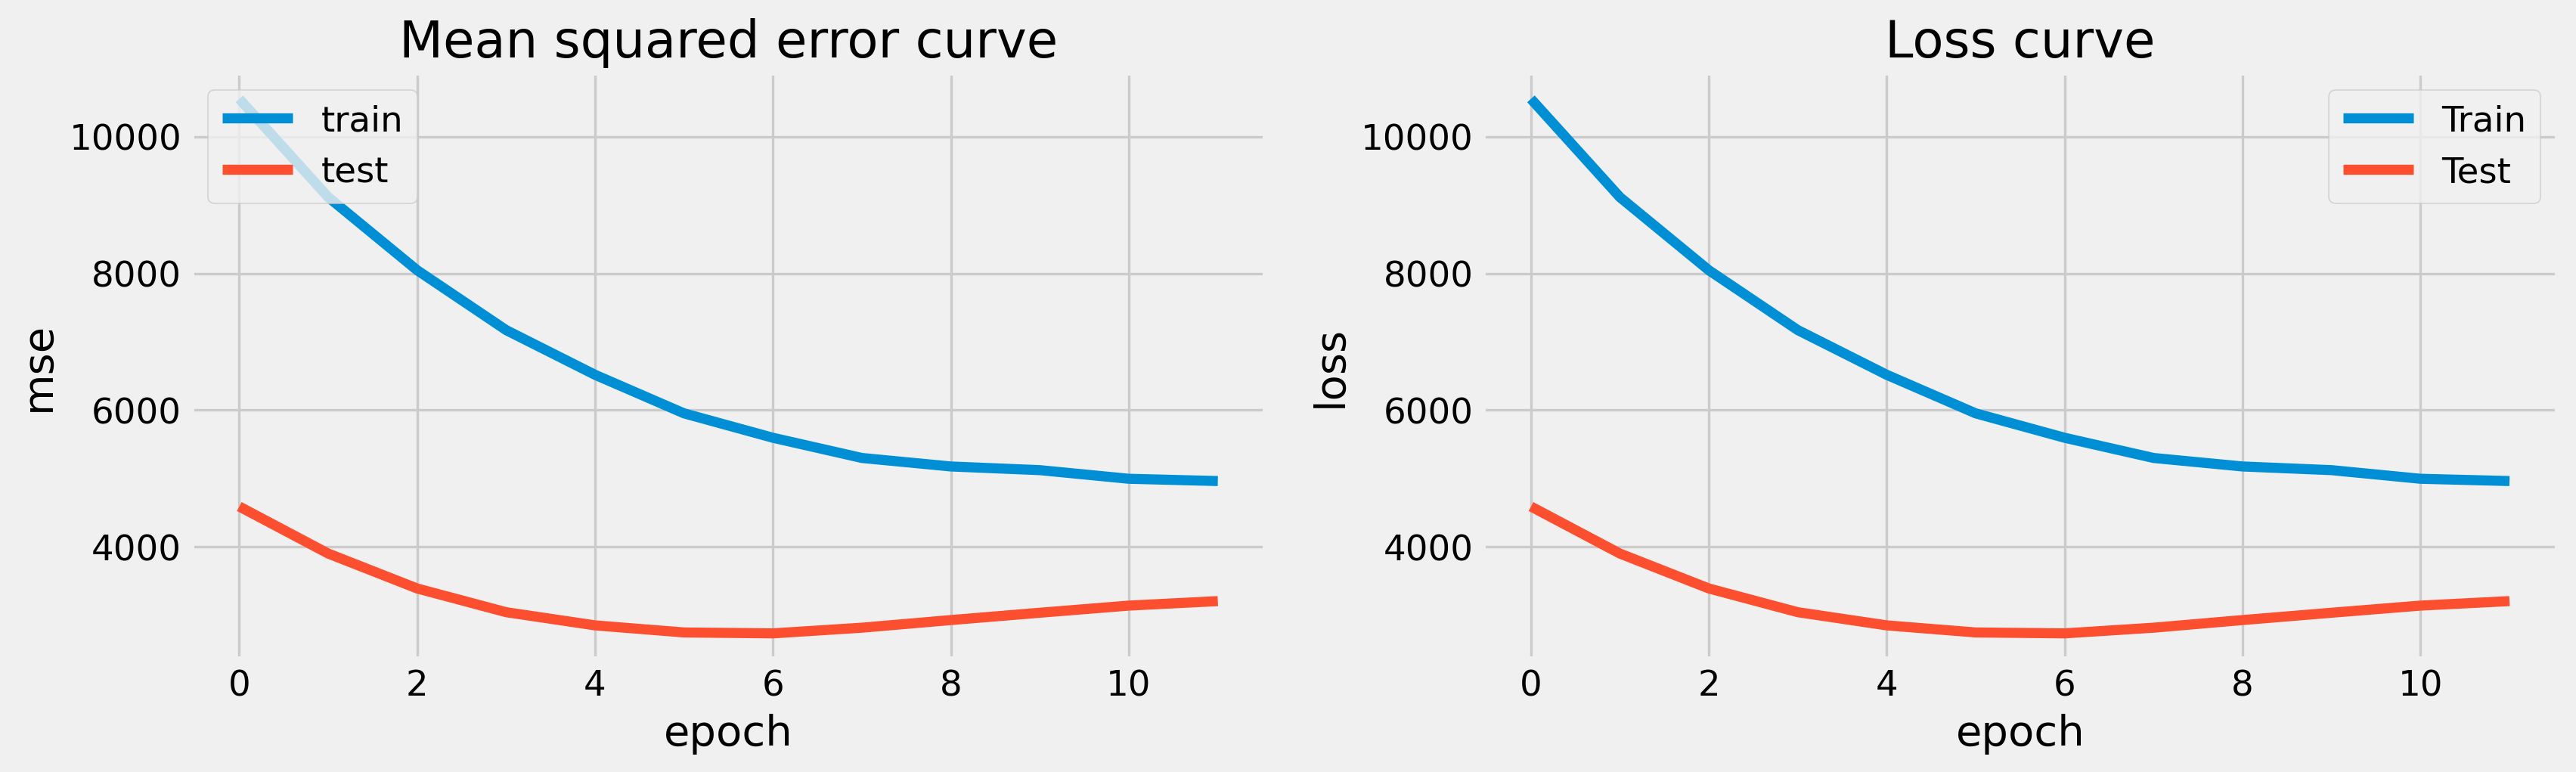

In [44]:
# plot loss funtion / learning curves
plot_validate('gru', gru_model)

### Forecasting

In [54]:
# define predictions holding array
test_predictions = []

# define train/test splits from time-series generators
X_train, X_test = train_gnr[0][0], test_gnr[0][1]
y_train, y_test = test_gnr[0][0], test_gnr[0][1]

# draw train & test prediction
predict_train = gru_model.predict_generator(train_gnr)
predict_test = gru_model.predict_generator(test_gnr)


In [ ]:
# define predictions holding array
test_predictions = []

# last n_input points from the training set
first_eval_batch = X_train[-time_steps:]
# reshape this to the format RNN wants (same format as TimeseriesGeneration)
current_batch = first_eval_batch.reshape((first_eval_batch.shape[0], time_steps, n_features))

# how far into the future will I forecast?
for i in range(len(ts_forecast)):
    
    # one timestep ahead of historical points
    current_pred = gru_model.predict(current_batch)[0]
    
    # store predictions
    test_predictions.append(current_pred)

# Fine-tuning

-------------------------------